##### TP integrador
Download Dataset here:
[Buenos Aires public bike system](https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download)



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from scipy.optimize import curve_fit



In [4]:
HTML('<a href="https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download" target="_blank">Download Dataset</a>')

In [5]:
df = pd.read_csv('./Datasets/recorridos-realizados-2018.csv', encoding='latin-1')
len(df)

1457509

In [6]:
df.head(2)
#df.info()

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad,bici_direccion,bici_pais
0,15728,26/05/2018 15:32:07,0:08:52,F. J. Santamaría de Oro,125,Acuña de Figueroa,54,M,28.0,TTE BENJAMIN MATIENZO,Argentina
1,26531,26/05/2018 3:42:41,0:30:49,Yatay,121,Hospital Garrahan,107,M,26.0,LAVALLE,Argentina


In [7]:
# Convertir fecha_hora_retiro a datetime

df.bici_Fecha_hora_retiro = df.bici_Fecha_hora_retiro.apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
df['date'] = df.bici_Fecha_hora_retiro.apply(lambda x: x.replace(minute=0, second=0))


Text(0.5, 1.0, 'Alquiler de bicis Julio 2016 - Julio 2018')

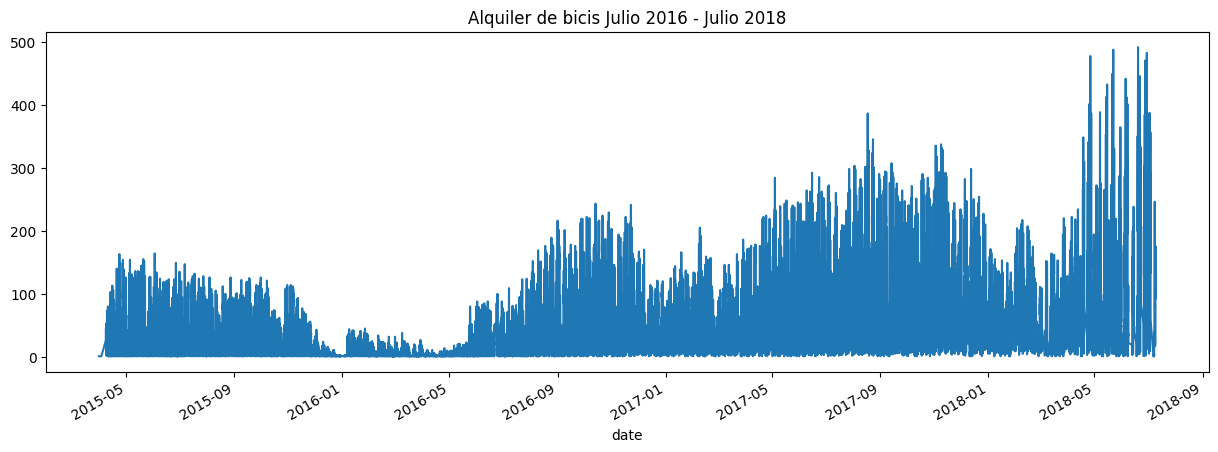

In [8]:
plt.figure(figsize=(15,5))
df.groupby('date').bici_id_usuario.count().plot()
plt.title('Alquiler de bicis Julio 2016 - Julio 2018')

#### Limpieza de datos

Observamos que hay muchos menos registros durante los primeros meses de 2016. Es por esta razón que tomaremos la decisión de achicar la serie y quedarnos con dos años de datos, desde Julio 2016 a Julio 2018.

In [38]:
fecha_limite = pd.to_datetime('2016-08-01 00:00:00')
df_shorten = df[df['date'] >= fecha_limite].copy()
bicis_por_dia = df_shorten.groupby('date').bici_id_usuario.count()

Text(0.5, 1.0, 'Alquiler de bicis Agosto 2016 - Julio 2018')

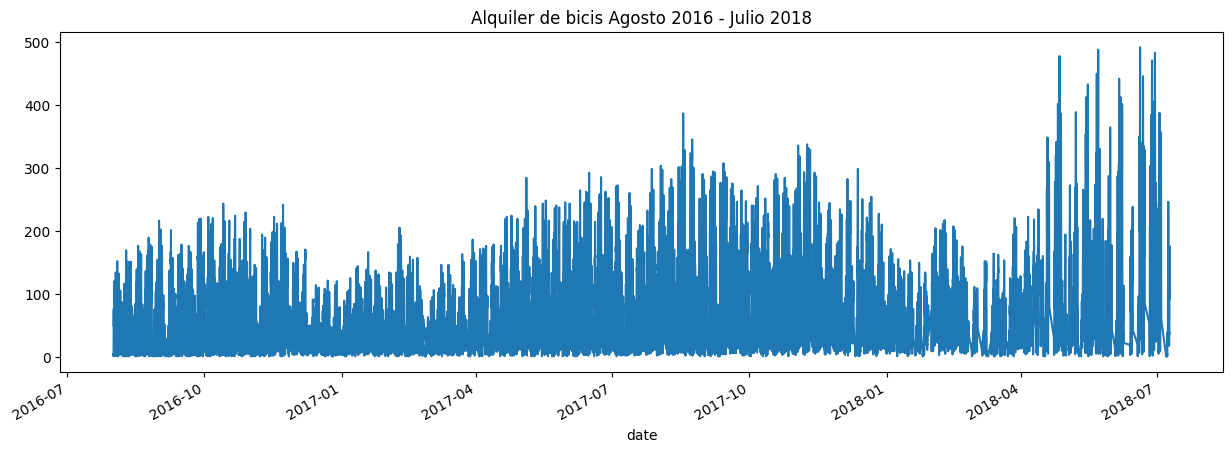

In [39]:
plt.figure(figsize=(15,5))
df_shorten.groupby('date').bici_id_usuario.count().plot()
plt.title('Alquiler de bicis Agosto 2016 - Julio 2018')

In [40]:
# Obtengo minutos de alquiler de bici

parse_duration = lambda duration_str: timedelta(
    hours=int(duration_str.split(':')[0]),
    minutes=int(duration_str.split(':')[1]) if len(duration_str.split(':')) >=2 else 0,
    seconds=int(duration_str.split(':')[2]) if len(duration_str.split(':')) >=3 else 0
)

df_shorten['bici_tiempo_uso_delta'] = df_shorten['bici_tiempo_uso'].apply(lambda x: parse_duration(x))
df_shorten['total_minutes'] = df_shorten['bici_tiempo_uso_delta'].dt.total_seconds() / 60

In [41]:
min(df_shorten.total_minutes), max(df_shorten.total_minutes)

(8.0, 1756.9166666666667)

Text(0.5, 1.0, 'Boxplot: duración de alquiler de bici (excluyendo outliers)')

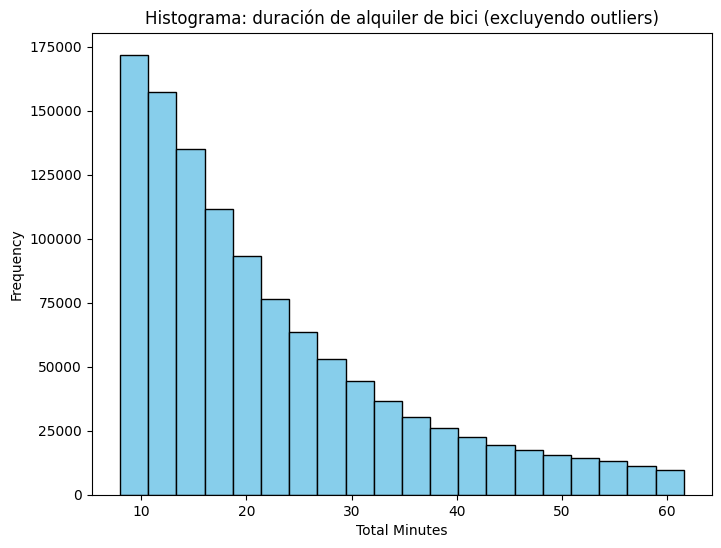

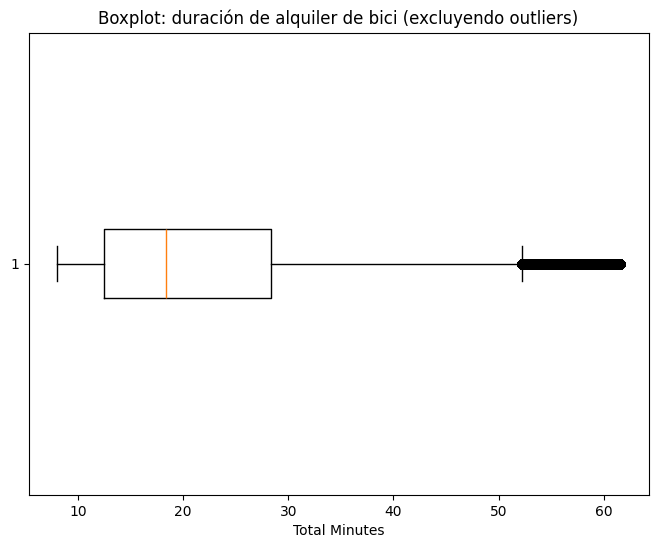

In [42]:
# Calculo quantiles
Q1 = df_shorten['total_minutes'].quantile(0.25)
Q3 = df_shorten['total_minutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtramos outliers
filtered_df = df_shorten[(df_shorten['total_minutes'] >= lower_bound) & (df_shorten['total_minutes'] <= upper_bound)]

plt.figure(figsize=(8, 6))
plt.hist(filtered_df['total_minutes'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Minutes')
plt.ylabel('Frequency')
plt.title('Histograma: duración de alquiler de bici (excluyendo outliers)')

plt.figure(figsize=(8, 6))
plt.boxplot(filtered_df['total_minutes'], vert=False)
plt.xlabel('Total Minutes')
plt.title('Boxplot: duración de alquiler de bici (excluyendo outliers)')


#### Observación
A partir del histograma observamos que la gran mayoría de los usuarios alquilan las bicicletas por períodos cortos menores a una hora. La media de uso está alrededor de los 20 minutos. 

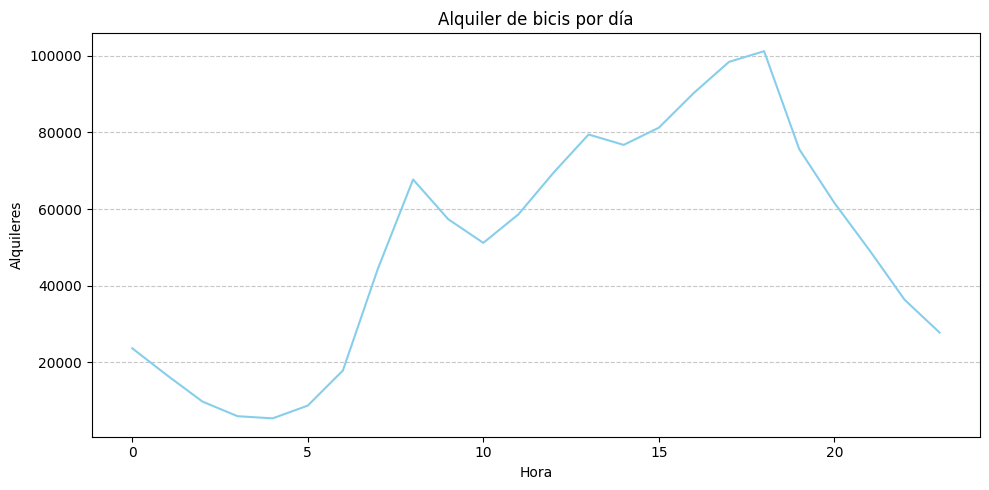

In [43]:
df_shorten['hour'] = df_shorten['date'].dt.hour
hourly_rentals = df_shorten.groupby('hour')['bici_id_usuario'].count()

plt.figure(figsize=(10, 5))
hourly_rentals.plot( color='skyblue')
plt.title('Alquiler de bicis por día')
plt.xlabel('Hora')
plt.ylabel('Alquileres')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


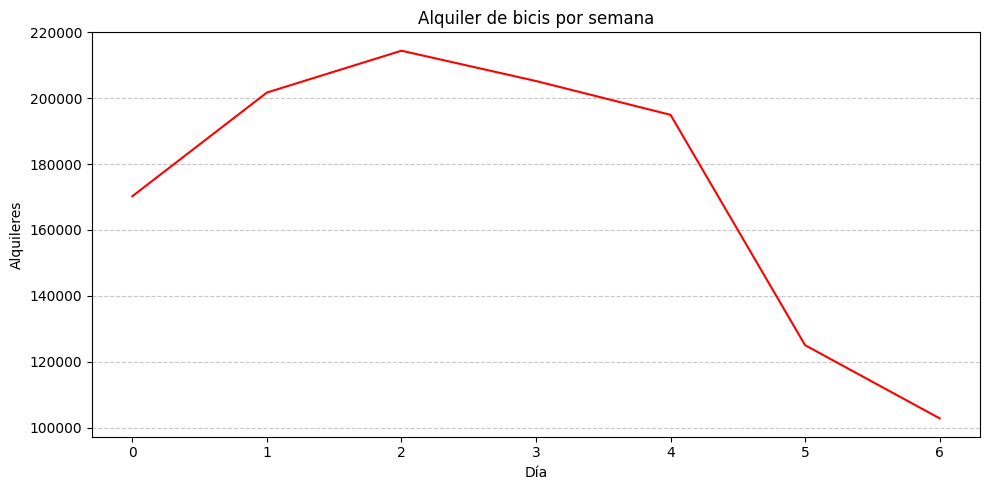

In [44]:
df_shorten['dia'] = df_shorten['date'].dt.weekday
weekly_rentals = df_shorten.groupby('dia')['bici_id_usuario'].count()

plt.figure(figsize=(10, 5))
weekly_rentals.plot( color='red')
plt.title('Alquiler de bicis por semana')
plt.xlabel('Día')
plt.ylabel('Alquileres')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Observación

De estos gráficos se desprende ue:
* de lunes a viernes hay más alquileres de bicis que durante los fines de semana. 
* Por otro lado, hay tres picos de alquileres a las 9 am, al mediodía y alrededor de las 18, lo que coincide con los horarios en que la mayoría de la gente va y vuelve de trabajar.
* La serie presenta valles en las horas no pico, con una drástica caída durante la madrugada.

##### 1 mes vs 6 meses de datos

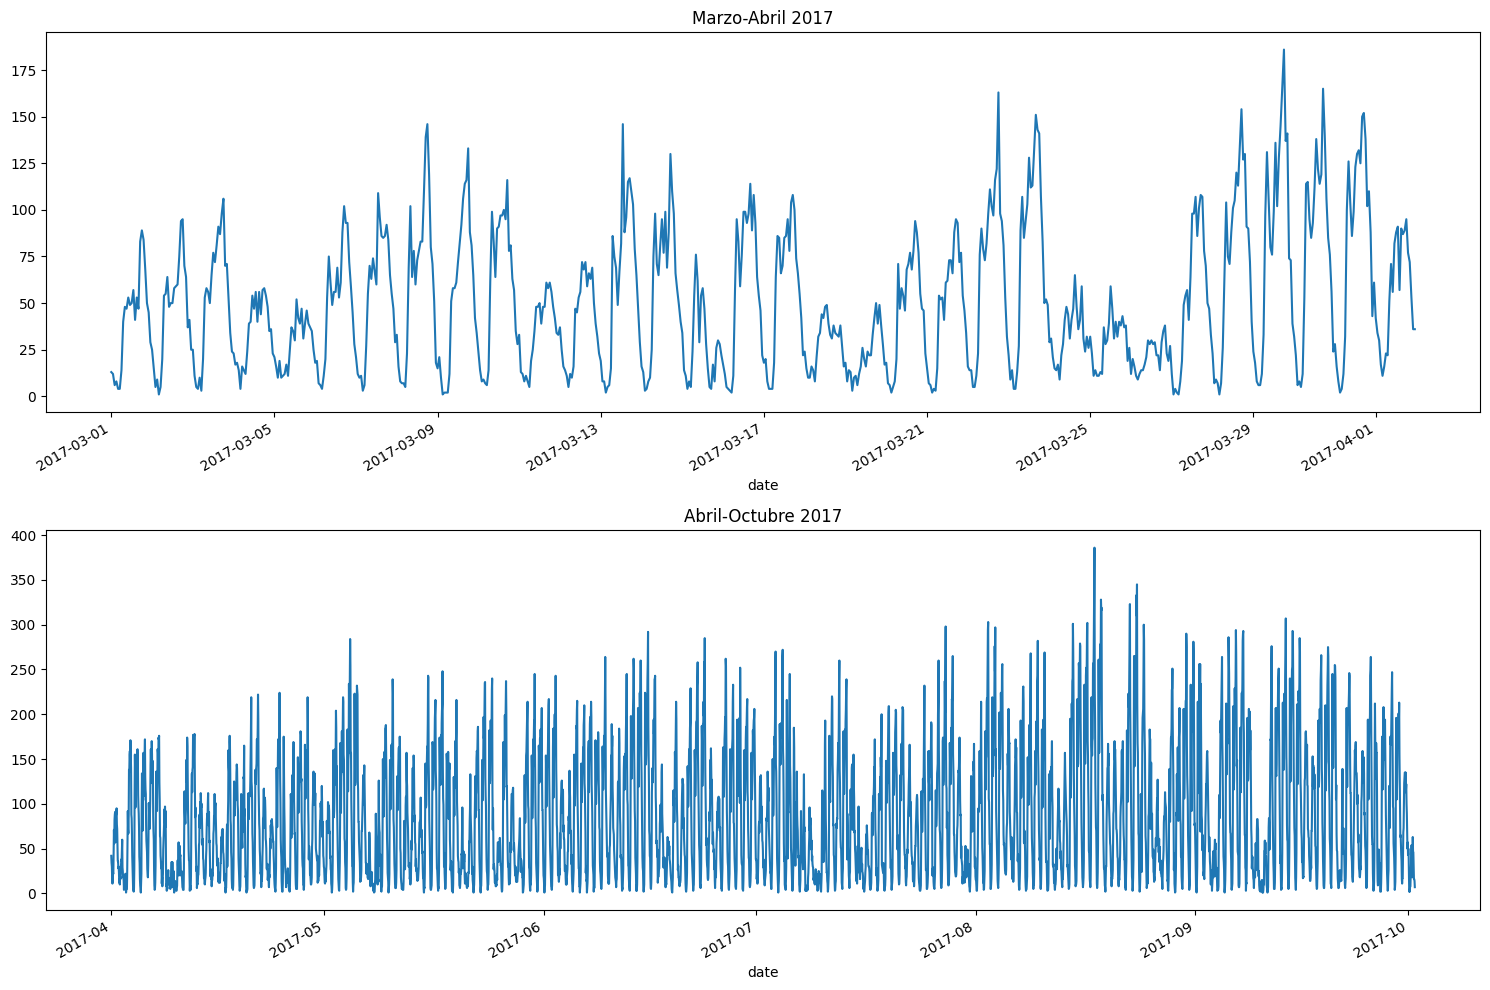

In [37]:
s = df.groupby('date').bici_id_usuario.count()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

## Visualización un mes de datos
s['2017-03-01': '2017-04-01'].plot(ax=axes[0])
axes[0].set_title('Marzo-Abril 2017')

# Visualización 6 meses de datos
s['2017-04-01': '2017-10-01'].plot(ax=axes[1])
axes[1].set_title('Abril-Octubre 2017')

plt.tight_layout()
plt.show()

#### Análisis
El dataset contiene información sobre el alquiler de bicicletas en la Ciudad de Buenos Aires durante el período Marzo 2015 - Julio 2018.

* En el gráfico de toda la serie se observa una tendencia alcista a partir del 2016 con dos valles marcados durante los meses de enero y febrero de 2017 y 2018 que coinciden con los meses donde la mayor cantidad de gente suele estar de vacaciones. 
La tendencia alcista podría deberse a un incremento en la adopción del servicio de alquiler de bicis.
* Se trata de una serie univariada y discreta 
* Graficamos también por día de la semana y por hora. Se observa cómo decae el alquiler durante los fines de semana y cómo la mayor cantidad de alquileres se da entre las 08 y las 20 horas, con un pico a la 18/19. Esto coincide con el horario en que la gente entra y sale de trabajar. Mientras que el alquiler cae drásticamente durante las horas de la madrugada.
* Graficando un mes de datos podemos observar cierta estacionalidad dada por los picos y valles entre semanas. 
* Graficando seis meses de datos en el período de Abril 2017 - Octubre 2017 vemos que la estacionalidad se mantiene.

#### Modelo aditivo de cuatro componentes 
A partir de la cantidad de usuario por día

In [93]:
rents = df_shorten.set_index('date')
rents = rents.resample('D').bici_id_usuario.count()

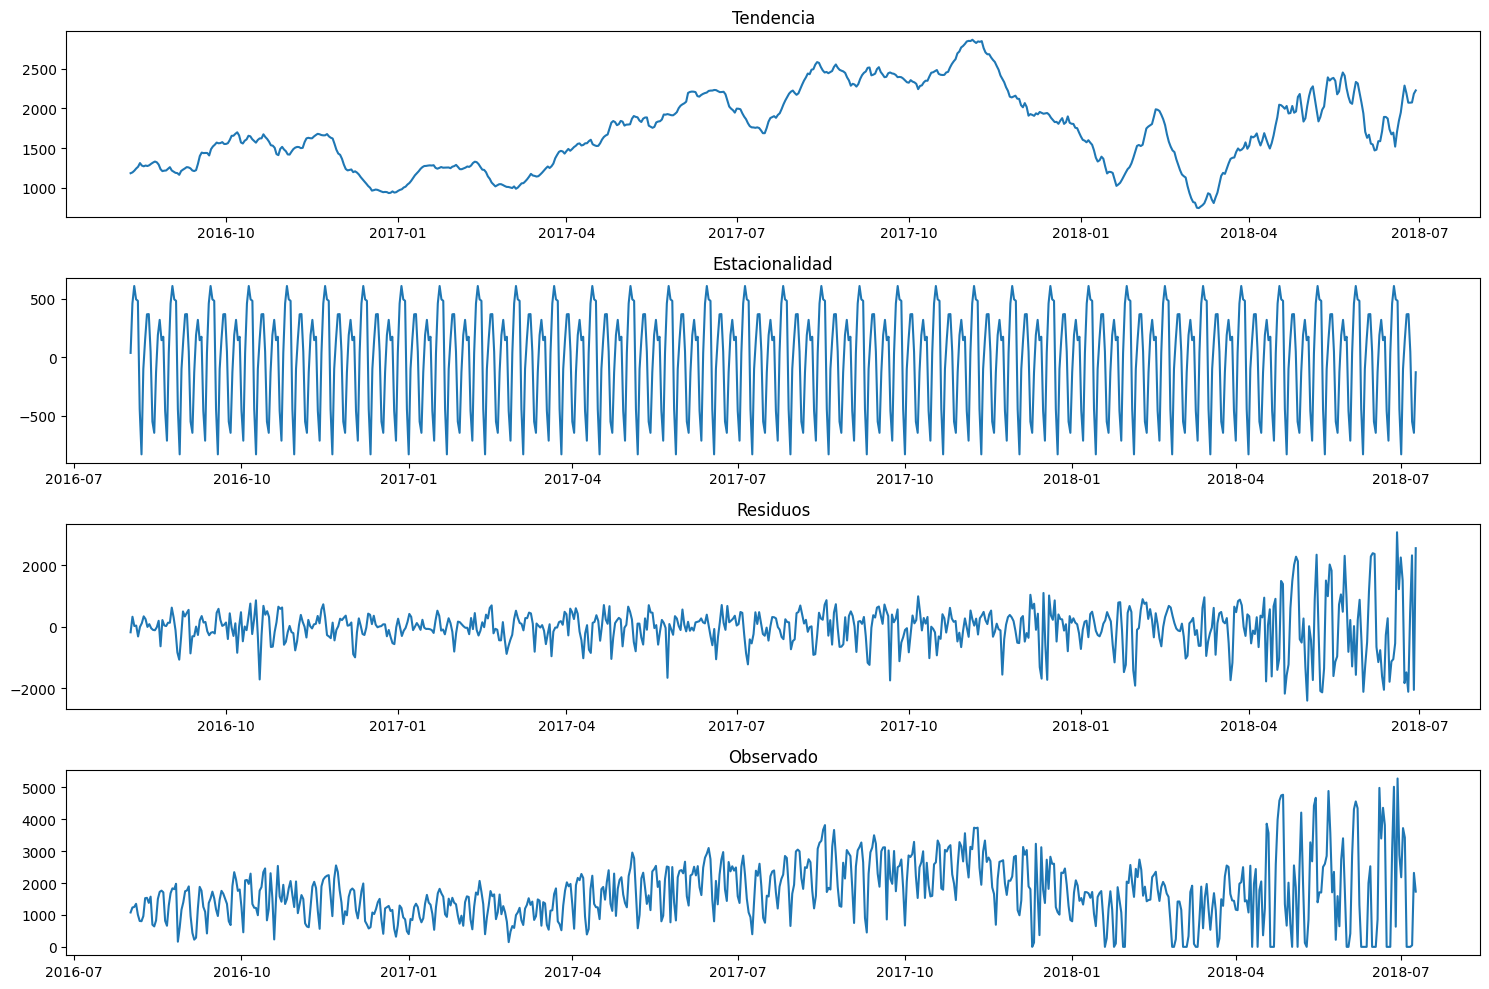

In [105]:
daily_result = seasonal_decompose(rents, model='additive', period=21)

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(daily_result.trend)
plt.title('Tendencia')

plt.subplot(4, 1, 2)
plt.plot(daily_result.seasonal)
plt.title('Estacionalidad')

plt.subplot(4, 1, 3)
plt.plot(daily_result.resid)
plt.title('Residuos')

plt.subplot(4, 1, 4)
plt.plot(daily_result.observed)
plt.title('Observado')

plt.tight_layout()
plt.show()

#### Análisis
* A partir de los gráficos podemos observary una tendencia alcista a partir de los meses de marzo y bajista a partir de diciembre. 
* Observamos una clara estacionalidad en la serie que coincide con lo visto en los gráficos intrasemanales e intradiarios.
* No parece haber ningún patrón en el residual (observado - (trend+seasonality))

#### Tiempo de uso del servicio

In [95]:
# Me quedo con la mediana 

daily_rentals = df_shorten.groupby(pd.Grouper(key='date', freq='D'))['total_minutes'].median().reset_index()
daily_rentals = daily_rentals.set_index('date')
daily_rentals.isna().sum()

total_minutes    36
dtype: int64

In [96]:
daily_rentals = daily_rentals.dropna()
daily_rentals = daily_rentals[daily_rentals.total_minutes < 1000]

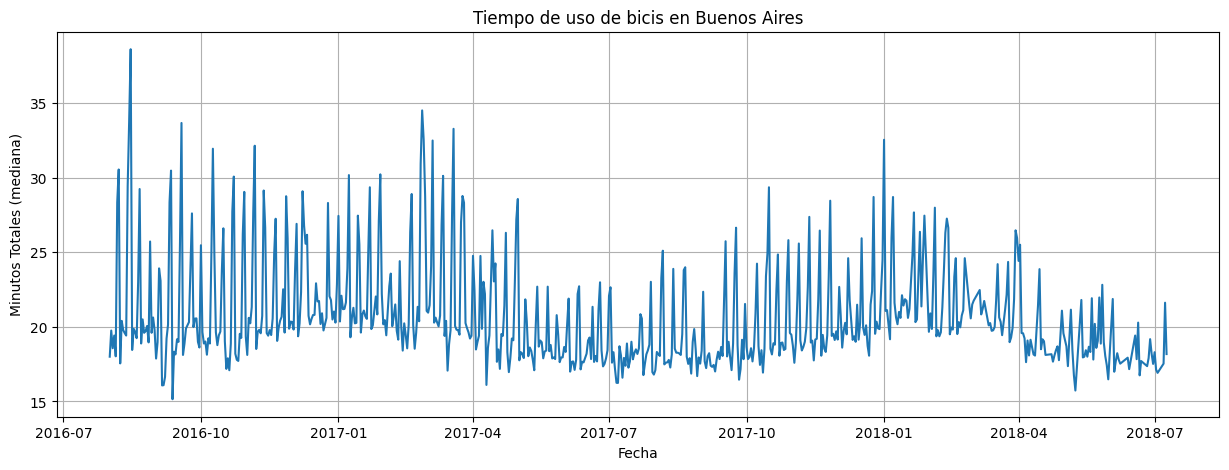

In [97]:
plt.figure(figsize=(15, 5))
plt.plot(daily_rentals.index, daily_rentals['total_minutes'])
plt.title('Tiempo de uso de bicis en Buenos Aires')
plt.xlabel('Fecha')
plt.ylabel('Minutos Totales (mediana)')
plt.grid(True)

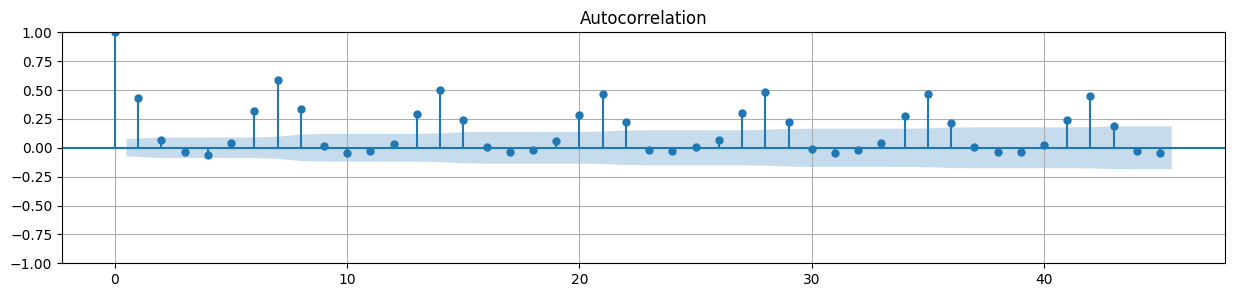

In [98]:
# Autocorrelacion

plt.figure(figsize=(15,3))
plot_acf(daily_rentals['total_minutes'], lags=45, ax=plt.gca())
plt.grid(True)
plt.show()

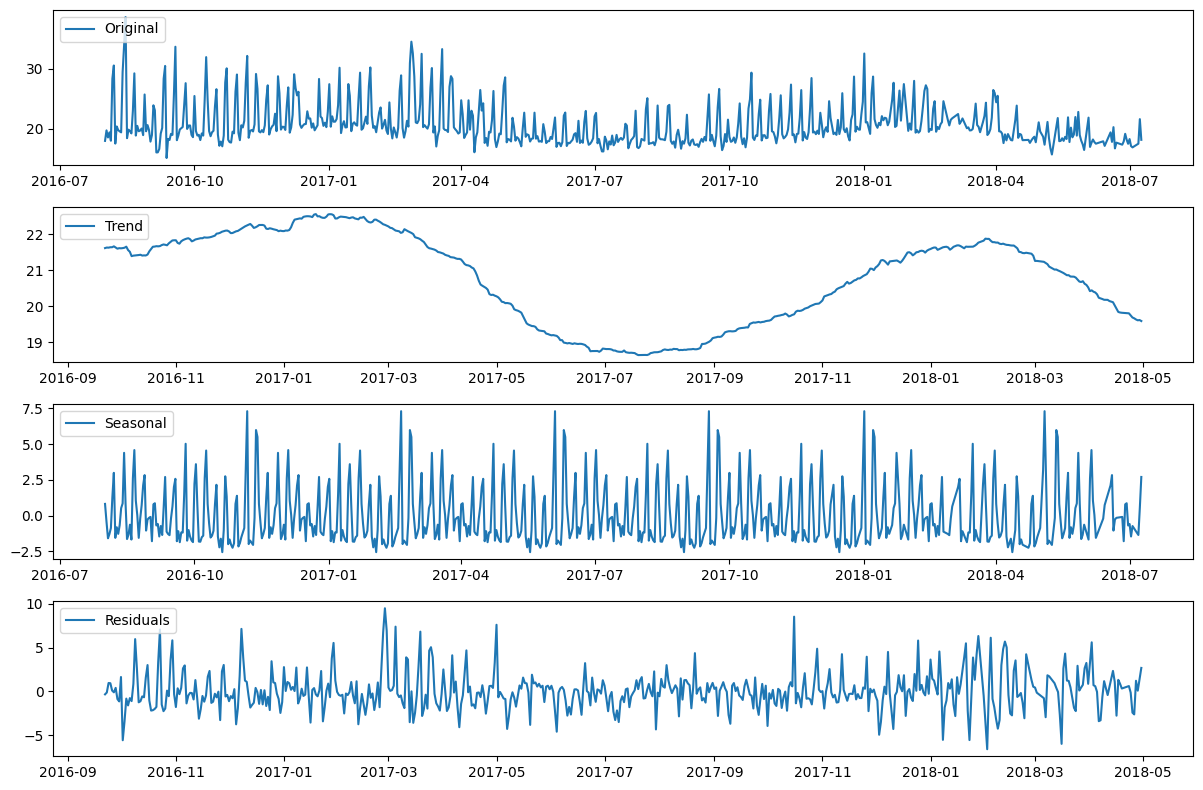

In [99]:
minutes_decompose = seasonal_decompose(daily_rentals['total_minutes'], model='additive', period=7*15)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(daily_rentals['total_minutes'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(minutes_decompose.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(minutes_decompose.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(minutes_decompose.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### Observación 

En estos gráficos podemos observar que:
* Hay una tendencia alcista en el tiempo de uso de la bicicleta a partir de noviembre, que coincide con los meses de verano. 
* Si bien, tal como vimos en los otros gráficos, cae el alquiler durante esos meses, al parecer los usuarios que usan las bicicletas lo hacen por períodos de tiempo más largos.
* Hay una tendencia bajista durante los meses de invierno, esto es, los usuarios pasan menos tiempo arriba de la bicicleta. 

#### Extraer la tendencia y ajustar un modelo determinístico:
Explicar su relación con el contexto. Obtener conclusiones acerca de la validez del modelo.


In [100]:
# Extraemos tendencia calculada a partir de la cantidad de usuario por día (es decir NO tiempo de uso calculado en minutos)

tendencia = daily_result.trend

tendencia = tendencia.dropna()

x_data = np.arange(len(tendencia))
y_data = tendencia

#### Observación:
Como en el gráfico de la tendencia vemos períodos que presentan picos y valles, esto es varios minimos y máximos locales, decidimos fitear un modelo de coseno.
Los picos no necesariamente están a una distancia regular, pero sí vemos que la amplitud varía. 

A continuación definimos un modelo de **coseno**

In [106]:
# a = amplitud, b=frecuencia, c=fase, d=offset

def cosine_model(x, a, b, c, d):
    return a * np.cos(b * x + c) + d

In [107]:
''' Definimos los valores iniciales de los parámetros:
a (amplitud) = 0
b (frecuencia) = 2*np.pi/365
c (fase) = 0
d (offset) = np.mean(y_data)

'''

popt, pcov = curve_fit(cosine_model, x_data, y_data,  p0=(0, 2*np.pi/365, 0, np.mean(y_data)))
y_fit = cosine_model(x_data, *popt)

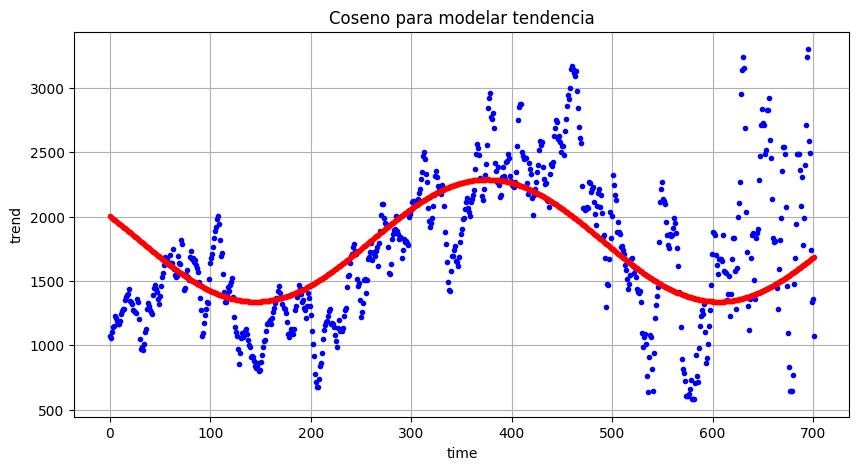

In [110]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('Coseno para modelar tendencia')  
plt.grid(True)

Podemos ver que la curva no pasa por la media en todos los puntos y qua hay mucha varianza hacia el final de la serie. 
Podríamos probar con otra familia de modelos o bien probar con un modelo de coseno con más parámetros como haremos a continuación:
De este modo tendremos dos cosenos diferentes, cada uno con su propia amplitud, frecuencia y fase.
intradiarios e intrasemanales. 


In [125]:
def double_cosine_model(x, a, b, c, d, e, f, g):
    """"Función para fitear un modelo coseno con 7 parámetros:
    a = amplitud
    b = frecuencia
    c = fase
    d = offset
    e = amplitud
    f = frecuencia
    g = fase
    """
    return a * np.cos(b * x + c) + d + e * np.cos(f * x + g)

In [127]:
popt, pcov = curve_fit(double_cosine_model, x_data, y_data, p0=(2500, 2*np.pi/365, 0, np.mean(y_data), 1, 2*np.pi/365*7, 0))
y_fit_double = double_cosine_model(x_data, *popt)


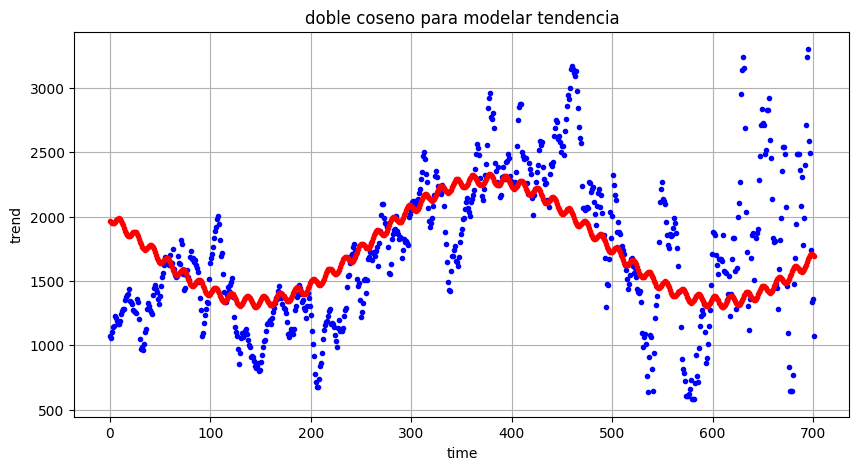

In [128]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit_double, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('doble coseno para modelar tendencia')  
plt.grid(True)

#### Realizo una búsqueda de mejores hiperparámetros

In [126]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())

best_rmse = None
best_sol = None

for i in range(1000):
    p0 = [np.random.randint(50, 5000), np.random.uniform(0.001, 0.5), np.random.random(), 
          np.random.randint(int(np.mean(y_data)/2),  int(np.mean(y_data)*2)), 
          np.random.randint(20, 1000), np.random.uniform(0.001, 0.75), np.random.random()]
    try:
        popt, pcov = curve_fit(double_cosine_model, x_data, y_data, p0=p0)
    except:
        continue

    y_fit = double_cosine_model(x_data, *popt)
    this_rmse = rmse(y_data, y_fit)
    if best_rmse is None or this_rmse < best_rmse:
        best_rmse = this_rmse
        best_sol = popt
        print("found better ", best_rmse)
    

found better  473.7763882645883


found better  472.117541611282
found better  471.98462685514073
found better  470.46268867473145
found better  469.2938309645477
found better  464.9827694203028
found better  462.02379871538835
found better  422.79004817281805
found better  422.7900425397636


#### Predigo con los mejores hiperparámetros, es decir la combinación que me da el menor rmse

In [129]:
y_fit_best= double_cosine_model(x_data, *best_sol)

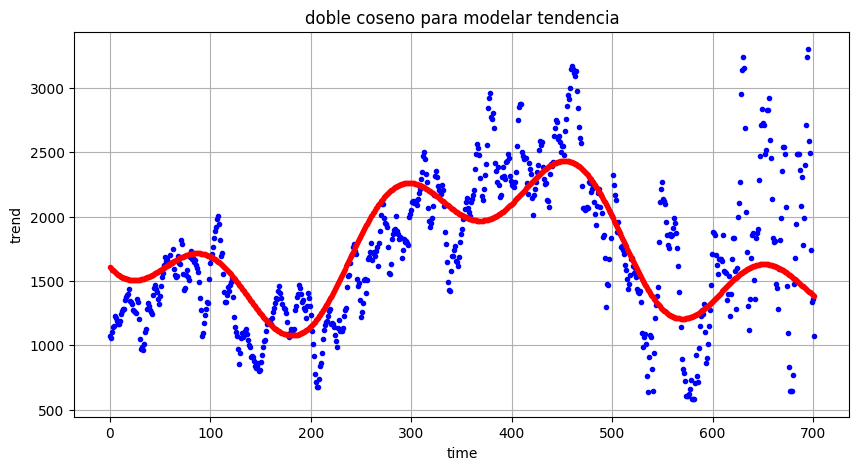

In [130]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit_best, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('doble coseno para modelar tendencia')  
plt.grid(True)


* Entrega clase 4: Evaluar si la serie original es estacionaria. Aplicar transformaciones
(preprocesamiento), graficar autocorrelación, autocorrelación parcial y extraer conclusiones.

#### Evaluar si la serie es estacionaria


In [123]:
bicis_por_dia.resample('D').sum()


date
2016-08-01    1077
2016-08-02    1233
2016-08-03    1249
2016-08-04    1348
2016-08-05    1008
              ... 
2018-07-05       0
2018-07-06       0
2018-07-07      50
2018-07-08    2317
2018-07-09    1730
Freq: D, Name: bici_id_usuario, Length: 708, dtype: int64

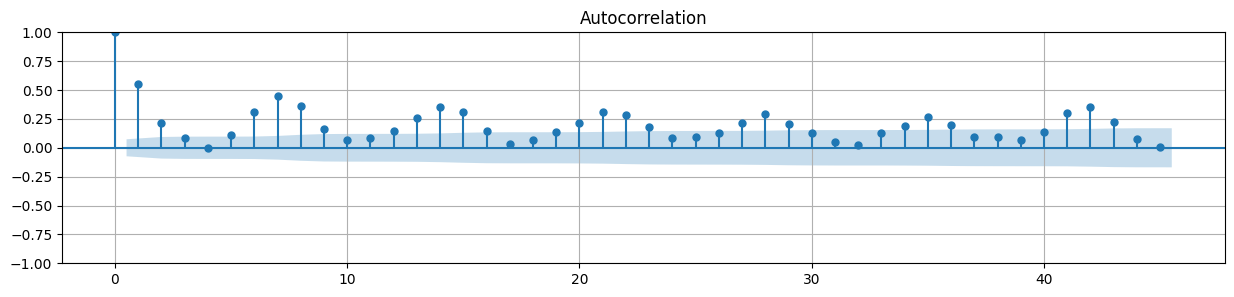

In [132]:
# calculo autocorrelación y autocorrelación parcial

plt.figure(figsize=(15,3))
plot_acf(bicis_por_dia.resample('D').sum(), lags=45, ax=plt.gca()) #lags=dias
plt.grid(True)
plt.show()


A partir de este gráfico de autocorrelación, podemos observar una clara autocorrelación intradiaria e intrasemanal, que coincide con lo observado en los gráficos más arriba, donde se ve la tendencia semanal (con más alquileres durante los días de semana) y por día (con tendencia alcista a partir de las 6 am y y bajista despues de las 11 de la noche). Se observan picos correspondientes a ciclos de 24 horas. 



In [ ]:
# autocorrelacion parcial

acf_values, conf_int = pacf(bicis_por_dia, alpha=0.05)

<Figure size 1200x600 with 0 Axes>

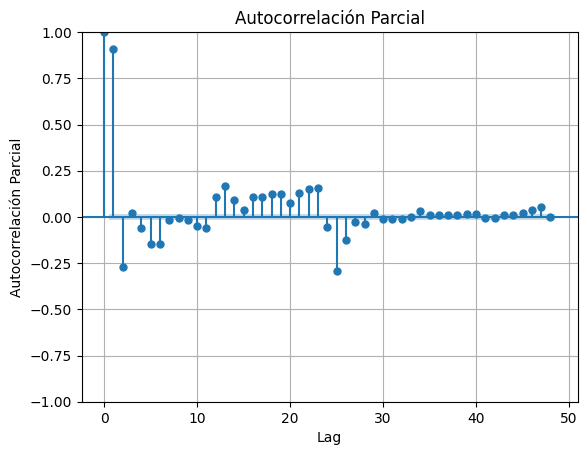

In [34]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12, 6))
plot_pacf(bicis_por_dia, lags=48, alpha=0.05)
plt.title('Autocorrelación Parcial')
plt.xlabel('Lag')   
plt.ylabel('Autocorrelación Parcial')
plt.grid(True)
plt.show()


A partir de este gráfico de autocorrelación parcial, observamos una autocorrelación fuerte cuando el lag = 1, esto nos sugiere que el valor de la serie de tiempo en una hora está muy influenciado por su valor en la hora anterior.
Pero a medida que nos movemos, las autocorrelaciones parciales tienden a ir disminuyendo y acercándose cada vez más a cero, lo que nos sugiere que la influencia del pasado o de las horas anteriores en la serie disminuye a medida que aumenta la distancia temporal.

In [ ]:
# aplico test de dickey fuller. Primero es necesario quitar trends, seasonality, diferenciasr

adf_result = adfuller(bicis_por_dia)
print('estadistica:', adf_result[0])
print('p valor:', adf_result[1])
print('valores criticos:', adf_result[2])

estadistica: -11.3292005016236
p valor: 1.1236442327391579e-20
valores criticos: 44


movimiento de hora
movimiento semanal
